<a href="https://colab.research.google.com/github/Mary-prh/food_classification_transfer-learning-/blob/main/Food_vision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9f6360cf-3474-0839-164a-c426fcd12496)


# **Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-10 16:47:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-10 16:47:39 (60.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

# **Download Data from Tensorflow**

In [4]:
import tensorflow_datasets as tfds

In [5]:
dataset_list = tfds.list_builders()
print('food101' in dataset_list)

True


In [6]:
(train_data, test_data), ds_info = tfds.load(name= 'food101' , shuffle_files= True ,
                                             split = ['train' , 'validation'], as_supervised= True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteLJRMMS/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteLJRMMS/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# **Data Exploratory**

**Take out the class names**

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
class_names = ds_info.features['label'].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [9]:
len(class_names)

101

**Take one sample off the training data**


---

The sample has two variables: first one is image (tf.uint8) and the second one is the label (tf.int64) as we saw in features info



In [10]:
train_sample =  train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

**Image Inforamtion:**


---



---



1.   The shape of our input data (image tensors)
2.   The datatype of our input data
3.   What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
4.   Do the labels match up with the class names?



In [11]:
for image , label in train_sample:
  print(f"""
  image shape: {image.shape}
  image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
   Class name (str form): {class_names[label.numpy()]}
   """)


  image shape: (384, 512, 3)
  image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
   Class name (str form): takoyaki
   


In [12]:
import tensorflow as tf

tf.reduce_min(image) , tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

**Visualize the selected image**

Text(0.5, 1.0, 'takoyaki')

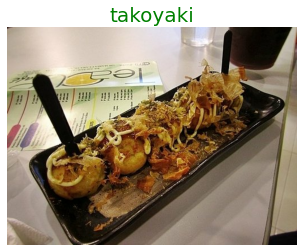

In [13]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False)
plt.title(class_names[label.numpy()], fontsize = 20, color = 'g')

# **Dataset Preprocessing Function**

---
models like data to be:
*   In `float32` data type
*   Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
*   Scaled (values between 0 & 1), also called normalized

In [14]:
def preprocess_image(image, label, image_shape=224):
  Image = tf.image.resize(image , size= [image_shape , image_shape])
  Image = tf.cast(Image , dtype=tf.float32)
  # Image = Image/255.
  return Image , label # so the output is a tupe of image and label

In [15]:
preproc_image = preprocess_image(image , label , 224)[0] # get the image, only
preproc_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 56.23469  ,  32.591835 ,  27.877552 ],
        [ 98.16328  ,  75.16328  ,  68.50001  ],
        [121.62245  , 101.62245  ,  91.63265  ],
        ...,
        [191.72456  , 191.36736  , 170.93883  ],
        [202.18863  , 196.9743   , 176.90286  ],
        [185.918    , 174.10167  , 153.6169   ]],

       [[ 93.47959  ,  73.55102  ,  64.19388  ],
        [144.57143  , 124.64286  , 113.561226 ],
        [169.66327  , 150.20409  , 138.79082  ],
        ...,
        [196.22955  , 195.22955  , 176.80103  ],
        [202.02025  , 194.9335   , 175.87225  ],
        [182.24942  , 168.44324  , 148.72888  ]],

       [[166.51021  , 149.08163  , 133.51021  ],
        [169.28572  , 151.85715  , 136.28572  ],
        [172.10204  , 155.67348  , 140.10204  ],
        ...,
        [193.92346  , 191.68872  , 174.21426  ],
        [200.37233  , 191.62741  , 174.35698  ],
        [180.43791  , 164.87663  , 145.44292  ]],

       ...,

     

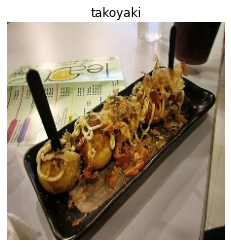

In [16]:
plt.imshow(preproc_image/255.)
plt.title(class_names[label])
plt.axis(False);

# **Batch & prepare datasets**

---
[Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

use the same pre-processing function but apply it in parallel on multiple samples.

In [17]:
train_data = train_data.map(map_func= preprocess_image , num_parallel_calls= tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size= 1000)
train_data = train_data.batch(batch_size= 32)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) # load it faster

In [18]:
test_data = test_data.map(map_func= preprocess_image , num_parallel_calls=tf.data.AUTOTUNE)
test_data  = test_data.batch(batch_size= 32)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
train_data , test_data
# None in image shape is a space for batches 

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# **Create modelling callbacks**

**we will call this function later during fitting the NN model**

In [20]:
from helper_functions import create_tensorboard_callback

**checkpiont callback**

In [21]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, 
                                                      monitor = 'val_accuracy', verbose =1 ,
                                                      save_best_only = True, save_weights_only = True)

# **Mixed Precision**

**Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).**

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

In [22]:
from tensorflow.keras import mixed_precision

In [23]:
mixed_precision.set_global_policy('mixed_float16')

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# **Build feature extraction model**

**Base model:**

In [25]:
from tensorflow.keras import applications

In [26]:
base_model = applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


**Model:**

**we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`**

In [27]:
Inputs = tf.keras.layers.Input(shape = [224, 224, 3], dtype = 'float16', name= 'Input_layer')

x = base_model(Inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name= 'Pooling_layer')(x)
x = tf.keras.layers.Dense(len(class_names) , name= 'Dense_layer')(x)

Outputs = tf.keras.layers.Activation('softmax' , dtype = 'float32' , name= 'prediction_layer')(x)

model_1 = tf.keras.Model(Inputs , Outputs)

**Compile:**

In [28]:
model_1.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [29]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dense_layer (Dense)         (None, 101)               129381    
                                                                 
 prediction_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [30]:
from gc import callbacks
history_1 = model_1.fit(train_data , steps_per_epoch= len(train_data),
                        epochs = 3 , validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)), 
                        callbacks = [model_checkpoint , 
                                     create_tensorboard_callback(dir_name= "training_logs", 
                                                                 experiment_name= "efficientnetb0_101_classes_all_data_feature_extract")])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220810-165719
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.5574
Epoch 1: val_accuracy improved from -inf to 0.67560, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 197s 75ms/step - loss: 1.8210 - accuracy: 0.5574 - val_loss: 1.2358 - val_accuracy: 0.6756
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.6651
Epoch 2: val_accuracy improved from 0.67560 to 0.69797, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 188s 79ms/step - loss: 1.2938 - accuracy: 0.6650 - val_loss: 1.1315 - val_accuracy: 0.6980
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1435 - accuracy: 0.7022
Epoch 3: val_accuracy improved from 0.69797 to 0.70400, saving model to model_checkpoints/cp.ckpt
2368/2368 [====================

In [31]:
results_feature_extract_model = model_1.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 67ms/step - loss: 1.0873 - accuracy: 0.7062


[1.0873117446899414, 0.7062178254127502]

**Evaluation:**

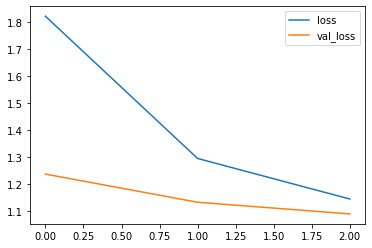

In [32]:
import pandas as pd

losses = pd.DataFrame(history_1.history)
losses[['loss', 'val_loss']].plot()

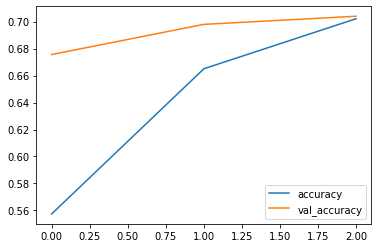

In [33]:
losses[['accuracy', 'val_accuracy']].plot()

# **Save**

In [34]:
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model_1.save(save_dir)

In [35]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

**Because we loaded the model, the layers will become trainable:**

In [36]:
for layer in loaded_saved_model.layers:
  print(layer.name, layer.trainable , layer.dtype , layer.dtype_policy)

Input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
Pooling_layer True float32 <Policy "mixed_float16">
Dense_layer True float32 <Policy "mixed_float16">
prediction_layer True float32 <Policy "float32">


**As we check the layers of the efficientnet, we can see that all layers are traninalbe which is what we want for training our big data**

In [37]:
for layer in loaded_saved_model.layers[1].layers[:10]:
  print(layer.name, layer.trainable , layer.dtype , layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">


In [38]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 51s 62ms/step - loss: 1.0873 - accuracy: 0.7062


[1.0873115062713623, 0.7062178254127502]

In [39]:
import numpy as np
np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

True

# **Fine Tuning Model**

In [40]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dense_layer (Dense)         (None, 101)               129381    
                                                                 
 prediction_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## **Callbacks**

---


In [41]:
import tensorflow as tf

In [42]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau

**Early Stopping**

In [43]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

**Checkpoint**

In [44]:
checkpoint_path = "fine_tune_checkpoints/"
checkpoint_callback = ModelCheckpoint(filepath= checkpoint_path , monitor='val_loss',
                                      save_best_only=True, save_weights_only=False, mode='auto')

**ReduceLROnPlateau**

In [45]:
Adjust_LR = ReduceLROnPlateau(monitor= 'val_loss', factor = 0.2,
                              verbose=1, # print out when learning rate goes down  
                              patience= 2, min_lr = 1e-7)

## **Recompile**

In [46]:
loaded_saved_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss= 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## **Fit the model**

In [47]:
history_2 = loaded_saved_model.fit(train_data, epochs=100,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(0.15*len(test_data)),
                                   callbacks=[early_stopping,checkpoint_callback,Adjust_LR, 
                                              create_tensorboard_callback(dir_name= "training_logs", 
                                                                 experiment_name= "efficientnetb0_101_classes_all_data_fine_tuning")])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tuning/20220810-170940
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.7510

2368/2368 [==============================] - 226s 92ms/step - loss: 0.9720 - accuracy: 0.7510 - val_loss: 1.0536 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9547 - accuracy: 0.7561

2368/2368 [==============================] - 221s 93ms/step - loss: 0.9548 - accuracy: 0.7561 - val_loss: 1.0450 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 173s 72ms/step - loss: 0.9438 - accuracy: 0.7591 - val_loss: 1.0497 - val_accuracy: 0.7217 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9341 - accuracy: 0.7624

2368/2368 [==============================] - 220s 92ms/step - loss: 0.9341 - accuracy: 0.7624 - val_loss: 1.0434 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9253 - accuracy: 0.7645

2368/2368 [==============================] - 222s 93ms/step - loss: 0.9253 - accuracy: 0.7645 - val_loss: 1.0415 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 173s 73ms/step - loss: 0.9170 - accuracy: 0.7666 - val_loss: 1.0436 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 7/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.9090 - accuracy: 0.7696

2368/2368 [==============================] - 215s 90ms/step - loss: 0.9090 - accuracy: 0.7696 - val_loss: 1.0307 - val_accuracy: 0.7227 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - 170s 71ms/step - loss: 0.9013 - accuracy: 0.7714 - val_loss: 1.0381 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 9/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8937 - accuracy: 0.7733
Epoch 9: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 171s 72ms/step - loss: 0.8937 - accuracy: 0.7732 - val_loss: 1.0441 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 10/100
2368/2368 [==============================] - 167s 70ms/step - loss: 0.8778 - accuracy: 0.7786 - val_loss: 1.0334 - val_accuracy: 0.7217 - lr: 2.0000e-05


In [49]:
loaded_saved_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [50]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip